<center> 
    <h1>Mini-project1</h1>
    <h2>Predict the laterality of upcoming finger movements</h2>
</center>

#### Imports

In [1]:
import math
import numpy as np
import matplotlib.pylab as plt
import dlc_bci as bci
from types import SimpleNamespace 

from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# baselines
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

import torch 
from torch.nn import Conv2d, Linear, functional, Module, CrossEntropyLoss
from torch import Tensor
from torch.autograd import Variable
from torch.optim import Adam
import torch.nn.functional as F

from helpers import *
from modelWrapper import *

## Download/load the dataset

- load the dataset

In [2]:
X_tr, y_tr = bci.load(root='./data_bci')
print(str(type(X_tr)), X_tr.size())
print(str(type(y_tr)), y_tr.size())

X_te, y_te = bci.load(root='./data_bci', train=False)
print(str(type(X_te)), X_te.size())
print(str(type(y_te)), y_te.size())

<class 'torch.FloatTensor'> torch.Size([316, 28, 50])
<class 'torch.LongTensor'> torch.Size([316])
<class 'torch.FloatTensor'> torch.Size([100, 28, 50])
<class 'torch.LongTensor'> torch.Size([100])


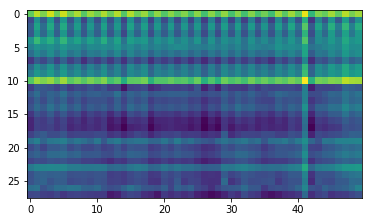

In [3]:
i = 30
plt.imshow(X_tr[i])
plt.show()

- Organize the dataset in train and test by also converting the X in array. 

In [4]:
train = SimpleNamespace()
train.X = SimpleNamespace()
train.X.variable = Variable(X_tr.unsqueeze(1))
train.X.numpy = X_tr.numpy().reshape(X_tr.shape[0], -1)
train.y = SimpleNamespace()
train.y.variable = Variable(y_tr)
train.y.numpy = y_tr.numpy()

test = SimpleNamespace()
test.X = SimpleNamespace()
test.X.variable = Variable(X_te.unsqueeze(1))
test.X.numpy = X_te.numpy().reshape(X_te.shape[0], -1)
test.y = SimpleNamespace()
test.y.variable = Variable(y_te)
test.y.numpy = y_te.numpy()

## Baselines:

### Logistic regression

In [77]:
lambdas = np.logspace(-6, 6, 20) # grid search on a parameter of the model

# here we store all the scores obtained with the different lambdas
logreg = {
    "tr_scores": [],
    "va_scores": []
}

for lambda_ in lambdas:
    result = cross_validate(LogisticRegression(C=lambda_), train.X.numpy, train.y.numpy, cv=10, return_train_score=True)
    
    logreg["tr_scores"].append(np.mean(result["train_score"]))
    logreg["va_scores"].append(np.mean(result["test_score"]))
    
plot_scores(lambdas, "lambda", logreg["tr_scores"], logreg["va_scores"], log_scale=True)

best_lambda = lambdas[np.argmax(logreg["va_scores"])]
print('Best lambda:', best_lambda)
print('Test score:', 
      LogisticRegression(C=best_lambda)
      .fit(train.X.numpy, train.y.numpy)
      .score(test.X.numpy, test.y.numpy))

Best lambda: 0.000335981828628
Test score: 0.71


### Random Forest

In [6]:
depths = np.arange(5, 100, 10) # grid search on a parameter of the model

# here we store all the scores obtained with the different depths
randForest = {
    "tr_scores": [],
    "va_scores": []
}

for depth in depths:
    result = cross_validate(
        RandomForestClassifier(n_estimators=100, max_depth=depth, n_jobs=-1, random_state=1), 
        train.X.numpy, train.y.numpy, cv=10, return_train_score=True)
    
    randForest["tr_scores"].append(np.mean(result["train_score"]))
    randForest["va_scores"].append(np.mean(result["test_score"]))
    
plot_scores(depths, "depth", randForest["tr_scores"], randForest["va_scores"], log_scale=False)

best_depth = depths[np.argmax(randForest["va_scores"])]
print('Best depth:', best_depth)
print('Test score:',
      RandomForestClassifier(n_estimators=100, max_depth=depth, n_jobs=-1, random_state=1)
      .fit(train.X.numpy, train.y.numpy)
      .score(test.X.numpy, test.y.numpy))

Best depth: 25
Test score: 0.58


### K-Nearest Neighbors

In [7]:
scaler = StandardScaler()
scaler.fit(train.X.numpy)
X_tr_scaled = scaler.transform(train.X.numpy)
X_te_scaled = scaler.transform(test.X.numpy)
print("standard deviation average:", X_tr_scaled.std(axis=0).mean())
print("mean average:", X_tr_scaled.mean(axis=0).mean())

standard deviation average: 1.0
mean average: 1.44916e-08


In [8]:
pca = PCA(n_components=0.95)
pca.fit(X_tr_scaled)
X_tr_scaled = pca.transform(X_tr_scaled)
X_te_scaled = pca.transform(X_te_scaled)
X_tr_scaled.shape, X_te_scaled.shape

((316, 20), (100, 20))

In [9]:
Ks = np.arange(1, 10, 1) # grid search on a parameter of the model

# here we store all the scores obtained with the different number of neighbors
nearestNeig = {
    "tr_scores": [],
    "va_scores": []
}

for k in Ks:
    result = cross_validate(
        KNeighborsClassifier(n_neighbors=k), 
        X_tr_scaled, train.y.numpy, cv=10, return_train_score=True)
    
    nearestNeig["tr_scores"].append(np.mean(result["train_score"]))
    nearestNeig["va_scores"].append(np.mean(result["test_score"]))
    
plot_scores(Ks, "# Neighbors", nearestNeig["tr_scores"], nearestNeig["va_scores"], log_scale=False)

best_k = Ks[np.argmax(nearestNeig["va_scores"])]
print('Best k:', best_k)
print('Test score:', 
      KNeighborsClassifier(n_neighbors=k)
      .fit(X_tr_scaled, train.y.numpy)
      .score(X_te_scaled, test.y.numpy))

Best k: 8
Test score: 0.54


## Convolutional networks

In [249]:
# define the network with two convolutional layers
class CNN(Module, modelWrapper):
    def __init__(self, nb_hidden):
        self.nb_hidden = nb_hidden
        super(CNN, self).__init__()
        
        self.conv1 = Conv2d(1, 32, kernel_size=(3, 7), padding=(1, 3)) 
        self.conv2 = Conv2d(32, 64, kernel_size=5, padding=2)
        self.conv3 = Conv2d(64, 32, kernel_size=5, padding=2)
#         self.conv4 = Conv2d(32, 16, kernel_size=5, padding=2)
        
        self.fc1 = Linear(384, nb_hidden)
        self.fc2 = Linear(nb_hidden, 2)
        
        self.criterion = CrossEntropyLoss()
        self.optimizer = Adam(self.parameters(), lr=0.01)

    def forward(self, x):
        # (1, 28, 50)
        print(x.size())
        x = F.leaky_relu(F.max_pool2d(self.conv1(x), 2))
        # (32, 14, 25)
        print(x.size())
        x = F.leaky_relu(F.max_pool2d(self.conv2(x), (2, 5)))
        # (64, 7, 5)
        print(x.size())
        x = F.leaky_relu(F.max_pool2d(self.conv3(x), 2, padding=(1, 1)))
        # (32, 4, 3)
        print(x.size())
        
        x = F.leaky_relu(self.fc1(x.view(-1, 384)))  
        # (1, nb_hidden)
        print(x.size())
        x = self.fc2(x)
        print(x.size())
        return x
    
    def reset(self):
        self.__init__(self.nb_hidden)

In [250]:
model = CNN(100)

In [251]:
model.fit(train.X.variable, train.y.variable, X_test=test.X.variable, y_test=test.y.variable, epochs=15)

torch.Size([20, 1, 28, 50])
torch.Size([20, 32, 14, 25])
torch.Size([20, 64, 7, 5])
torch.Size([20, 32, 4, 3])
torch.Size([20, 100])
torch.Size([20, 2])
torch.Size([20, 1, 28, 50])
torch.Size([20, 32, 14, 25])
torch.Size([20, 64, 7, 5])
torch.Size([20, 32, 4, 3])
torch.Size([20, 100])
torch.Size([20, 2])
torch.Size([20, 1, 28, 50])
torch.Size([20, 32, 14, 25])
torch.Size([20, 64, 7, 5])
torch.Size([20, 32, 4, 3])
torch.Size([20, 100])
torch.Size([20, 2])
torch.Size([20, 1, 28, 50])
torch.Size([20, 32, 14, 25])
torch.Size([20, 64, 7, 5])
torch.Size([20, 32, 4, 3])
torch.Size([20, 100])
torch.Size([20, 2])
torch.Size([20, 1, 28, 50])
torch.Size([20, 32, 14, 25])
torch.Size([20, 64, 7, 5])
torch.Size([20, 32, 4, 3])
torch.Size([20, 100])
torch.Size([20, 2])
torch.Size([20, 1, 28, 50])
torch.Size([20, 32, 14, 25])
torch.Size([20, 64, 7, 5])
torch.Size([20, 32, 4, 3])
torch.Size([20, 100])
torch.Size([20, 2])
torch.Size([20, 1, 28, 50])
torch.Size([20, 32, 14, 25])
torch.Size([20, 64, 7, 5]

torch.Size([316, 64, 7, 5])
torch.Size([316, 32, 4, 3])
torch.Size([316, 100])
torch.Size([316, 2])
torch.Size([100, 1, 28, 50])
torch.Size([100, 32, 14, 25])
torch.Size([100, 64, 7, 5])
torch.Size([100, 32, 4, 3])
torch.Size([100, 100])
torch.Size([100, 2])
Epoch 2: Train loss: 112.336998462677. Train accuracy 0.50%. Test accuracy 0.49%
torch.Size([20, 1, 28, 50])
torch.Size([20, 32, 14, 25])
torch.Size([20, 64, 7, 5])
torch.Size([20, 32, 4, 3])
torch.Size([20, 100])
torch.Size([20, 2])
torch.Size([20, 1, 28, 50])
torch.Size([20, 32, 14, 25])
torch.Size([20, 64, 7, 5])
torch.Size([20, 32, 4, 3])
torch.Size([20, 100])
torch.Size([20, 2])
torch.Size([20, 1, 28, 50])
torch.Size([20, 32, 14, 25])
torch.Size([20, 64, 7, 5])
torch.Size([20, 32, 4, 3])
torch.Size([20, 100])
torch.Size([20, 2])
torch.Size([20, 1, 28, 50])
torch.Size([20, 32, 14, 25])
torch.Size([20, 64, 7, 5])
torch.Size([20, 32, 4, 3])
torch.Size([20, 100])
torch.Size([20, 2])
torch.Size([20, 1, 28, 50])
torch.Size([20, 32, 

torch.Size([16, 1, 28, 50])
torch.Size([16, 32, 14, 25])
torch.Size([16, 64, 7, 5])
torch.Size([16, 32, 4, 3])
torch.Size([16, 100])
torch.Size([16, 2])
torch.Size([316, 1, 28, 50])
torch.Size([316, 32, 14, 25])
torch.Size([316, 64, 7, 5])
torch.Size([316, 32, 4, 3])
torch.Size([316, 100])
torch.Size([316, 2])
torch.Size([100, 1, 28, 50])
torch.Size([100, 32, 14, 25])
torch.Size([100, 64, 7, 5])
torch.Size([100, 32, 4, 3])
torch.Size([100, 100])
torch.Size([100, 2])
Epoch 5: Train loss: 27.00086548924446. Train accuracy 0.50%. Test accuracy 0.49%
torch.Size([20, 1, 28, 50])
torch.Size([20, 32, 14, 25])
torch.Size([20, 64, 7, 5])
torch.Size([20, 32, 4, 3])
torch.Size([20, 100])
torch.Size([20, 2])
torch.Size([20, 1, 28, 50])
torch.Size([20, 32, 14, 25])
torch.Size([20, 64, 7, 5])
torch.Size([20, 32, 4, 3])
torch.Size([20, 100])
torch.Size([20, 2])
torch.Size([20, 1, 28, 50])
torch.Size([20, 32, 14, 25])
torch.Size([20, 64, 7, 5])
torch.Size([20, 32, 4, 3])
torch.Size([20, 100])
torch.Si

torch.Size([20, 1, 28, 50])
torch.Size([20, 32, 14, 25])
torch.Size([20, 64, 7, 5])
torch.Size([20, 32, 4, 3])
torch.Size([20, 100])
torch.Size([20, 2])
torch.Size([20, 1, 28, 50])
torch.Size([20, 32, 14, 25])
torch.Size([20, 64, 7, 5])
torch.Size([20, 32, 4, 3])
torch.Size([20, 100])
torch.Size([20, 2])
torch.Size([16, 1, 28, 50])
torch.Size([16, 32, 14, 25])
torch.Size([16, 64, 7, 5])
torch.Size([16, 32, 4, 3])
torch.Size([16, 100])
torch.Size([16, 2])
torch.Size([316, 1, 28, 50])
torch.Size([316, 32, 14, 25])
torch.Size([316, 64, 7, 5])
torch.Size([316, 32, 4, 3])
torch.Size([316, 100])
torch.Size([316, 2])
torch.Size([100, 1, 28, 50])
torch.Size([100, 32, 14, 25])
torch.Size([100, 64, 7, 5])
torch.Size([100, 32, 4, 3])
torch.Size([100, 100])
torch.Size([100, 2])
Epoch 8: Train loss: 11.88922768831253. Train accuracy 0.53%. Test accuracy 0.44%
torch.Size([20, 1, 28, 50])
torch.Size([20, 32, 14, 25])
torch.Size([20, 64, 7, 5])
torch.Size([20, 32, 4, 3])
torch.Size([20, 100])
torch.Si

torch.Size([20, 1, 28, 50])
torch.Size([20, 32, 14, 25])
torch.Size([20, 64, 7, 5])
torch.Size([20, 32, 4, 3])
torch.Size([20, 100])
torch.Size([20, 2])
torch.Size([20, 1, 28, 50])
torch.Size([20, 32, 14, 25])
torch.Size([20, 64, 7, 5])
torch.Size([20, 32, 4, 3])
torch.Size([20, 100])
torch.Size([20, 2])
torch.Size([20, 1, 28, 50])
torch.Size([20, 32, 14, 25])
torch.Size([20, 64, 7, 5])
torch.Size([20, 32, 4, 3])
torch.Size([20, 100])
torch.Size([20, 2])
torch.Size([16, 1, 28, 50])
torch.Size([16, 32, 14, 25])
torch.Size([16, 64, 7, 5])
torch.Size([16, 32, 4, 3])
torch.Size([16, 100])
torch.Size([16, 2])
torch.Size([316, 1, 28, 50])
torch.Size([316, 32, 14, 25])
torch.Size([316, 64, 7, 5])
torch.Size([316, 32, 4, 3])
torch.Size([316, 100])
torch.Size([316, 2])
torch.Size([100, 1, 28, 50])
torch.Size([100, 32, 14, 25])
torch.Size([100, 64, 7, 5])
torch.Size([100, 32, 4, 3])
torch.Size([100, 100])
torch.Size([100, 2])
Epoch 11: Train loss: 12.078323900699615. Train accuracy 0.51%. Test a

torch.Size([20, 32, 14, 25])
torch.Size([20, 64, 7, 5])
torch.Size([20, 32, 4, 3])
torch.Size([20, 100])
torch.Size([20, 2])
torch.Size([20, 1, 28, 50])
torch.Size([20, 32, 14, 25])
torch.Size([20, 64, 7, 5])
torch.Size([20, 32, 4, 3])
torch.Size([20, 100])
torch.Size([20, 2])
torch.Size([16, 1, 28, 50])
torch.Size([16, 32, 14, 25])
torch.Size([16, 64, 7, 5])
torch.Size([16, 32, 4, 3])
torch.Size([16, 100])
torch.Size([16, 2])
torch.Size([316, 1, 28, 50])
torch.Size([316, 32, 14, 25])
torch.Size([316, 64, 7, 5])
torch.Size([316, 32, 4, 3])
torch.Size([316, 100])
torch.Size([316, 2])
torch.Size([100, 1, 28, 50])
torch.Size([100, 32, 14, 25])
torch.Size([100, 64, 7, 5])
torch.Size([100, 32, 4, 3])
torch.Size([100, 100])
torch.Size([100, 2])
Epoch 14: Train loss: 11.756706833839417. Train accuracy 0.50%. Test accuracy 0.51%


CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 7), stride=(1, 1), padding=(1, 3))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(64, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=384, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=2, bias=True)
  (criterion): CrossEntropyLoss(
  )
)

In [46]:
# model.predict(train.X.variable).shape, train.X.variable.shape
# model.score(train.X.variable, train.y.variable)

In [5]:
# define the network with two convolutional layers
class CNN2(Module, modelWrapper):
    def __init__(self):
#         self.nb_hidden = nb_hidden
        super(CNN2, self).__init__()
        
        self.conv1_1 = Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv1_2 = Conv2d(32, 32, kernel_size=3, padding=1) 
        self.conv1_3 = Conv2d(32, 32, kernel_size=3, padding=1) 
        
        self.conv2_1 = Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv2_2 = Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv2_3 = Conv2d(64, 64, kernel_size=3, padding=1)
        
        self.conv3_1 = Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3_2 = Conv2d(128, 128, kernel_size=3, padding=1)
        self.conv3_3 = Conv2d(128, 128, kernel_size=3, padding=1)
        
        self.fc1 = Linear(1536, 200)
        self.fc2 = Linear(200, 2)
        
        self.criterion = CrossEntropyLoss()
        self.optimizer = Adam(self.parameters(), lr=0.001)

    def forward(self, x):
        # (1, 28, 50)
        x = F.relu(self.conv1_1(x))
        x = F.relu(self.conv1_2(x))
        x = F.relu(F.max_pool2d(self.conv1_3(x), 2))
        # (32, 14, 25)
        x = F.relu(self.conv2_1(x))
        x = F.relu(self.conv2_2(x))
        x = F.relu(F.max_pool2d(self.conv2_3(x), (2, 5)))
        # (64, 7, 5)
        x = F.relu(self.conv3_1(x))
        x = F.relu(self.conv3_2(x))
        x = F.relu(F.max_pool2d(self.conv3_3(x), 2, padding=(1, 1)))
        # (128, 4, 3)
        
        x = F.relu(self.fc1(x.view(-1, 1536)))  
        # (1, nb_hidden)
        x = self.fc2(x)
        return x
    
    def reset(self):
        self.__init__(self.nb_hidden)

In [6]:
model = CNN2()
model.fit(train.X.variable, train.y.variable, X_test=test.X.variable, y_test=test.y.variable, epochs=35)

Epoch 0: Train loss: 11.404888451099396. Train accuracy 0.50%. Test accuracy 0.49%
Epoch 1: Train loss: 11.091134250164032. Train accuracy 0.50%. Test accuracy 0.49%
Epoch 2: Train loss: 11.09055757522583. Train accuracy 0.50%. Test accuracy 0.49%
Epoch 3: Train loss: 11.090853095054626. Train accuracy 0.50%. Test accuracy 0.49%
Epoch 4: Train loss: 11.090347051620483. Train accuracy 0.50%. Test accuracy 0.49%
Epoch 5: Train loss: 11.090041279792786. Train accuracy 0.50%. Test accuracy 0.49%
Epoch 6: Train loss: 11.089851438999176. Train accuracy 0.50%. Test accuracy 0.49%
Epoch 7: Train loss: 11.090090930461884. Train accuracy 0.50%. Test accuracy 0.49%
Epoch 8: Train loss: 11.086677312850952. Train accuracy 0.50%. Test accuracy 0.49%
Epoch 9: Train loss: 11.093389689922333. Train accuracy 0.70%. Test accuracy 0.62%
Epoch 10: Train loss: 10.205883145332336. Train accuracy 0.53%. Test accuracy 0.52%
Epoch 11: Train loss: 11.448211193084717. Train accuracy 0.60%. Test accuracy 0.60%
Epo

CNN2(
  (conv1_1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1536, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=2, bias=True)
  (criterion): CrossEntropyLoss(
  )
)

In [16]:
# resudial network
class BasicBlock(nn.Module):
    def __init__(self, in_planes, out_planes, stride, dropRate=0.0):
        super(BasicBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.droprate = dropRate
        self.equalInOut = (in_planes == out_planes)
        self.convShortcut = (not self.equalInOut) and nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride,
                               padding=0, bias=False) or None
    def forward(self, x):
        if not self.equalInOut:
            x = self.relu1(self.bn1(x))
        else:
            out = self.relu1(self.bn1(x))
        out = self.relu2(self.bn2(self.conv1(out if self.equalInOut else x)))
        if self.droprate > 0:
            out = F.dropout(out, p=self.droprate, training=self.training)
        out = self.conv2(out)
        return torch.add(x if self.equalInOut else self.convShortcut(x), out)

class NetworkBlock(nn.Module):
    def __init__(self, nb_layers, in_planes, out_planes, block, stride, dropRate=0.0):
        super(NetworkBlock, self).__init__()
        self.layer = self._make_layer(block, in_planes, out_planes, nb_layers, stride, dropRate)
    def _make_layer(self, block, in_planes, out_planes, nb_layers, stride, dropRate):
        layers = []
        for i in range(nb_layers):
            layers.append(block(i == 0 and in_planes or out_planes, out_planes, i == 0 and stride or 1, dropRate))
        return nn.Sequential(*layers)
    def forward(self, x):
        return self.layer(x)

class WideResNet(nn.Module, modelWrapper):
    def __init__(self, depth, num_classes, widen_factor=1, dropRate=0.0):
        super(WideResNet, self).__init__()
        nChannels = [16, 16*widen_factor, 32*widen_factor, 64*widen_factor]
        assert((depth - 4) % 6 == 0)
        n = int((depth - 4) / 6)
        block = BasicBlock
        # 1st conv before any network block
        self.conv1 = nn.Conv2d(1, nChannels[0], kernel_size=3, stride=1,
                               padding=1, bias=False)
        # 1st block
        self.block1 = NetworkBlock(n, nChannels[0], nChannels[1], block, 1, dropRate)
        # 2nd block
        self.block2 = NetworkBlock(n, nChannels[1], nChannels[2], block, 2, dropRate)
        # 3rd block
        self.block3 = NetworkBlock(n, nChannels[2], nChannels[3], block, 2, dropRate)
        # global average pooling and classifier
        self.bn1 = nn.BatchNorm2d(nChannels[3])
        self.relu = nn.ReLU(inplace=True)
        #self.fc = nn.Linear(nChannels[3], num_classes)
        #self.nChannels = nChannels[3]
        self.fc = nn.Linear(1152, num_classes)
        self.nChannels = 1152
        
        self.criterion = CrossEntropyLoss()
        self.optimizer = Adam(self.parameters(), lr=0.01)

#         for m in self.modules():
#             if isinstance(m, nn.Conv2d):
#                 n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
#                 m.weight.data.normal_(0, math.sqrt(2. / n))
#             elif isinstance(m, nn.BatchNorm2d):
#                 m.weight.data.fill_(1)
#                 m.bias.data.zero_()
#             elif isinstance(m, nn.Linear):
#                 m.bias.data.zero_()

    def forward(self, x):
        #print(x.size())
        out = self.conv1(x)
        #print(out.size())
        out = self.block1(out)
        #print(out.size())
        out = self.block2(out)
        #print(out.size())
        out = self.block3(out)
        #print(out.size())
        out = self.relu(self.bn1(out))
        #print(out.size())
        out = F.avg_pool2d(out, 2)
        #print(out.size())
        out = self.fc(out.view(-1, self.nChannels))
        #print(out.size())
        return out

In [17]:
model = WideResNet(depth=16, num_classes=2)

In [18]:
model.fit(train.X.variable, train.y.variable, X_test=test.X.variable, y_test=test.y.variable, epochs=50)

Epoch 0: Train loss: 14.618014931678772. Train accuracy 0.51%. Test accuracy 0.55%
Epoch 1: Train loss: 13.109021425247192. Train accuracy 0.51%. Test accuracy 0.56%
Epoch 2: Train loss: 12.39171290397644. Train accuracy 0.49%. Test accuracy 0.50%
Epoch 3: Train loss: 11.53100448846817. Train accuracy 0.50%. Test accuracy 0.49%
Epoch 4: Train loss: 11.063185453414917. Train accuracy 0.54%. Test accuracy 0.55%
Epoch 5: Train loss: 11.020868241786957. Train accuracy 0.59%. Test accuracy 0.59%
Epoch 6: Train loss: 11.078294575214386. Train accuracy 0.58%. Test accuracy 0.49%
Epoch 7: Train loss: 11.080949068069458. Train accuracy 0.56%. Test accuracy 0.48%
Epoch 8: Train loss: 11.1778843998909. Train accuracy 0.57%. Test accuracy 0.56%
Epoch 9: Train loss: 11.046930432319641. Train accuracy 0.63%. Test accuracy 0.52%
Epoch 10: Train loss: 10.76177579164505. Train accuracy 0.61%. Test accuracy 0.56%
Epoch 11: Train loss: 10.493326127529144. Train accuracy 0.62%. Test accuracy 0.54%
Epoch 1

WideResNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (block1): NetworkBlock(
    (layer): Sequential(
      (0): BasicBlock(
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (1): BasicBlock(
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
    )
 